In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from keras import saving
import os
import numpy as np
import cv2
import mediapipe as mp
from PIL import Image, ImageOps

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [4]:
WORK_DIR = "../"
DATA_DIR = "data/fingerspelling_detection/alphabet_data/"
DATASET_DIR = "data/fingerspelling_detection/"
TF_MODEL_DIR = "models/auslan_alphabet_classifier/"
MODEL_DIR = "models/"

In [135]:
os.makedirs(TF_MODEL_DIR, exist_ok=True)

# Dataset Preparation

In [5]:
# Get the list of all files and directories
all_subdirs = os.listdir(WORK_DIR + DATA_DIR)

# Filter out only directories
subdirs = [item for item in all_subdirs if os.path.isdir(os.path.join(WORK_DIR + DATA_DIR, item))]

print(subdirs)
# all_items

['r', 'u', 'i', 'n', 'g', 'z', 't', 's', 'a', 'f', 'o', 'h', 'm', 'j', 'c', 'd', 'v', 'q', 'x', 'e', 'b', 'k', 'l', 'y', 'p', 'w']


In [6]:
df = pd.DataFrame(columns=['imageid','label'])

In [7]:
for dir in subdirs:
    all_items = os.listdir(WORK_DIR + DATA_DIR + dir)
    size = len(all_items)
    if size < 100:
        continue
    labels = [dir] * size
    df_dir = pd.DataFrame({
        'imageid': all_items,
        'label': labels
    })
    df = pd.concat([df, df_dir], ignore_index=True)

In [139]:
df.head()

,imageid,label
0,24_7_2022_183_signer_frame_75.jpg,r
1,video_66_49_signer_frame_100.jpg,r
2,24_7_2022_213_signer_frame_237.jpg,r
3,video_22_211_signer_frame_45.jpg,r
4,video_4_67_signer_frame_132.jpg,r


In [8]:
len(df['label'].value_counts())

22

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9868 entries, 0 to 9867
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   imageid  9868 non-null   object
 1   label    9868 non-null   object
dtypes: object(2)
memory usage: 154.3+ KB


In [10]:
df.to_csv(WORK_DIR + 'auslan_alphabet_ds.csv', index=False)

---

In [11]:
df = pd.read_csv(WORK_DIR + 'auslan_alphabet_ds.csv', index_col=False)

# Image Standardization

In [12]:
IMAGE_SIZE = 224
PADDING_COLOUR = [0, 255, 0]
CROP_MARGIN = 50

In [13]:
def resize_image(image, height=IMAGE_SIZE, width=IMAGE_SIZE):
    image = Image.fromarray(image)
    image.thumbnail((width, height))
    image = np.asarray(image)
    y_border = max(height - image.shape[0], 0)
    x_border = max(width - image.shape[1], 0)
    top = y_border
    bottom = 0
    left = x_border
    right = 0
    image = cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=PADDING_COLOUR
    )
    return image

In [14]:
hands = mp.solutions.hands.Hands()


def get_2hands_coord(image_rgb):
    result = hands.process(image_rgb)
    height, width, _ = image_rgb.shape
    # Check if hands are detected

    left_x = width
    right_x = 0
    bottom_y = height
    top_y = 0

    if result.multi_hand_landmarks:
        x_coordinates = []
        y_coordinates = []
        for hand_landmarks in result.multi_hand_landmarks:
            if len(result.multi_hand_landmarks) < 2:
                print("Cannot detect two hands to crop the picture. Shrink it manually by 50%")
                x_coordinates = [0.25, 0.75]
                y_coordinates = [0.2, 0.7]
                break
            # Draw landmarks on the frame
            # mp.solutions.drawing_utils.draw_landmarks(image_rgb, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)

            # Get the top left corner of the detected hand's bounding box.
            for landmark in hand_landmarks.landmark:
                x_coordinates.append(landmark.x)
                y_coordinates.append(landmark.y)

        left_x = int(min(x_coordinates) * width)
        right_x = int(max(x_coordinates) * width)
        bottom_y = int(min(y_coordinates) * height)
        top_y = int(max(y_coordinates) * height)

    return (left_x, right_x, top_y, bottom_y)

I0000 00:00:1727398208.001895  106014 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Pro


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1727398208.007457  186311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1727398208.010859  186311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [15]:
def crop_image(image, left_x, right_x, top_y, bottom_y):
    orig_height, orig_width, _ = image.shape

    if left_x > right_x:
        tmp = left_x
        left_x = right_x
        right_x = tmp
    if bottom_y > top_y:
        tmp = top_y
        top_y = bottom_y
        bottom_y = tmp

    left_x = max(left_x - CROP_MARGIN, 0)
    right_x = min(right_x + CROP_MARGIN, orig_width)
    bottom_y = max(bottom_y - CROP_MARGIN, 0)
    top_y = min(top_y + CROP_MARGIN, orig_height)

    cropped_image = image[bottom_y:top_y, left_x:right_x]

    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)

    return cropped_image

In [49]:
img = cv2.imread(WORK_DIR + DATA_DIR + 'b/video_18_161_signer_frame_81.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [50]:
(left_x, right_x, top_y, bottom_y) = get_2hands_coord(img)
crop_img = crop_image(img, left_x, right_x, top_y, bottom_y)
final_img = resize_image(crop_img)

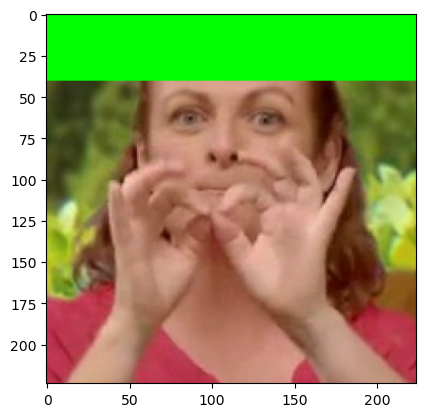

In [51]:
plt.imshow(final_img)
plt.show()

In [19]:
final_img.shape

(224, 224, 3)

# Data Loading

In [20]:
labels = df['label'].unique()
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=labels
)
print(label_processor.get_vocabulary())

['r', 'u', 'i', 'n', 'g', 't', 's', 'a', 'f', 'o', 'm', 'c', 'd', 'v', 'x', 'e', 'b', 'k', 'l', 'y', 'p', 'w']


In [21]:
def prepare_a_image(imageid, label):
    img = cv2.imread(WORK_DIR + DATA_DIR + label + '/' + imageid)
    (left_x, right_x, top_y, bottom_y) = get_2hands_coord(img)
    crop_img = crop_image(img, left_x, right_x, top_y, bottom_y)
    final_img = resize_image(crop_img)

    return final_img

In [22]:
def prepare_all_images(df):
    num_samples = len(df)
    X = np.zeros(shape=(num_samples, IMAGE_SIZE, IMAGE_SIZE, 3), dtype="int32")
    labels = []
    for idx, row in df.iterrows():
        imageid = row['imageid']
        label = row['label']
        print(f'Processing {imageid} with label {label}')
        
        x = prepare_a_image(imageid, label)

        X[idx, ] = x.squeeze()
        labels.append(label)

    Y = keras.ops.convert_to_numpy(label_processor(list(labels)))
    print(X.shape)
    print(Y.shape)
    return X, Y
        

In [23]:
X, Y = prepare_all_images(df)

Processing 24_7_2022_183_signer_frame_75.jpg with label r
Processing video_66_49_signer_frame_100.jpg with label r
Cannot detect two hands to crop the picture. Shrink it manually by 50%
Processing 24_7_2022_213_signer_frame_237.jpg with label r
Cannot detect two hands to crop the picture. Shrink it manually by 50%
Processing video_22_211_signer_frame_45.jpg with label r
Processing video_4_67_signer_frame_132.jpg with label r
Cannot detect two hands to crop the picture. Shrink it manually by 50%
Processing video_69_56_signer_frame_53.jpg with label r
Processing 24_7_2022_58_signer_frame_216.jpg with label r
Cannot detect two hands to crop the picture. Shrink it manually by 50%
Processing 30_10_2022_141_signer_frame_100.jpg with label r
Processing 16_10_2022_113_signer_frame_37.jpg with label r
Processing video_85_115_signer_frame_45.jpg with label r
Processing 30_10_2022_173_signer_frame_103.jpg with label r
Cannot detect two hands to crop the picture. Shrink it manually by 50%
Processi

In [24]:
print(X.shape)
print(Y.shape)

(9868, 224, 224, 3)
(9868,)


# Data Split

In [25]:
splitter_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=84)
# splitter_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=84)

In [26]:
for train_index, test_index in splitter_train_test.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

In [27]:
print(X_train.shape)
print(X_test.shape)

(7894, 224, 224, 3)
(1974, 224, 224, 3)


# Data Preprocessing

In [28]:
BATCH_SIZE = 20

In [29]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    rotation_range=20,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    rotation_range=20,
)

train_images = train_generator.flow(
    x=X_train,
    y=y_train,
    batch_size=20,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow(
    x=X_train,
    y=y_train,
    batch_size=20,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow(
    x=X_test,
    y=y_test,
    batch_size=20,
    shuffle=False
)

# Model Building

In [41]:
# reuse all the layers except for the output layer: include_top=False.
pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg' # reduces each feature map to a single value by averaging,
)

# freeze the reused layers during the first few epochs.
pretrainedModel.trainable = False

# input layer is same.
inputs = pretrainedModel.input

# output layer: add custom layers on top.
x = tf.keras.layers.Dense(256, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

# create the final model.
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so
# there will be large error gradients that may wreck the reused weights. To avoid this,
# one approach is to freeze the reused layers during the first few epochs, 
# giving the new layer some time to learn reasonable weights.
# default learning rate (LR) of the Adam optimizer in TensorFlow/Keras is 0.001.
adam = tf.keras.optimizers.Adam(
    learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

# always compile your model after you freeze or unfreeze layers.
model.compile(
    optimizer=adam,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,628,502 (10.03 MB)

 Trainable params: 370,518 (1.41 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training

In [42]:
# train the model for a few epochs.
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 47s 143ms/step - accuracy: 0.1273 - loss: 2.9600 - val_accuracy: 0.1965 - val_loss: 2.6758
Epoch 2/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 44s 136ms/step - accuracy: 0.2625 - loss: 2.5461 - val_accuracy: 0.2567 - val_loss: 2.5140
Epoch 3/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - accuracy: 0.3483 - loss: 2.2294 - val_accuracy: 0.3245 - val_loss: 2.2501
Epoch 4/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - accuracy: 0.3878 - loss: 2.0452 - val_accuracy: 0.3485 - val_loss: 2.1883
Epoch 5/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 45s 140ms/step - accuracy: 0.4601 - loss: 1.8619 - val_accuracy: 0.3701 - val_loss: 2.1503
Epoch 6/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - accuracy: 0.4853 - loss: 1.7350 - val_accuracy: 0.4202 - val_loss: 1.9538
Epoch 7/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 44s 136ms/step - accuracy: 0.5238 - loss: 1.6111 - val_accuracy: 0.4354 - val_loss: 1.9154
Epoch 8/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 45s 140ms/step - accuracy: 0.5363 - loss: 1

In [43]:
# unfreeze the reused layers.
for layer in model.layers[:-4]:
    layer.trainable = True

# after unfreezing the reused layers, it is usually a good idea to reduce the learning rate.
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

# compiling the model again.
model.compile(
    optimizer=adam,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
# continue training to fine-tune the reused layers.
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=40,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
    ],
)

Epoch 1/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 179s 540ms/step - accuracy: 0.2198 - loss: 3.2690 - val_accuracy: 0.5684 - val_loss: 1.7213
Epoch 2/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 168s 528ms/step - accuracy: 0.3632 - loss: 2.2423 - val_accuracy: 0.5330 - val_loss: 1.7850
Epoch 3/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 171s 537ms/step - accuracy: 0.4689 - loss: 1.8316 - val_accuracy: 0.5139 - val_loss: 1.7872
Epoch 4/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 172s 541ms/step - accuracy: 0.4962 - loss: 1.6276 - val_accuracy: 0.5152 - val_loss: 1.7581
Epoch 5/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 169s 532ms/step - accuracy: 0.5706 - loss: 1.4014 - val_accuracy: 0.5450 - val_loss: 1.6228
Epoch 6/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 166s 522ms/step - accuracy: 0.6132 - loss: 1.2620 - val_accuracy: 0.5425 - val_loss: 1.6160
Epoch 7/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 160s 505ms/step - accuracy: 0.6255 - loss: 1.1873 - val_accuracy: 0.5634 - val_loss: 1.5201
Epoch 8/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 160s 505ms/step - accuracy: 0.6495 -

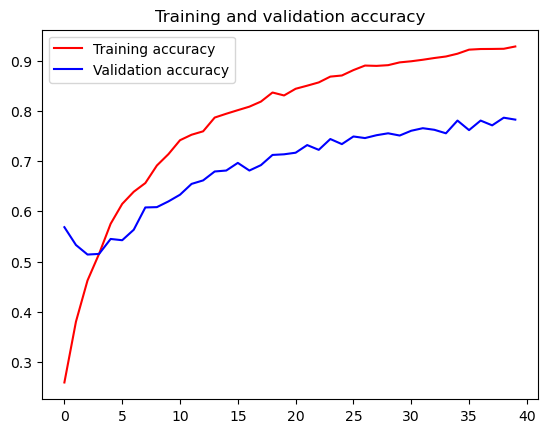

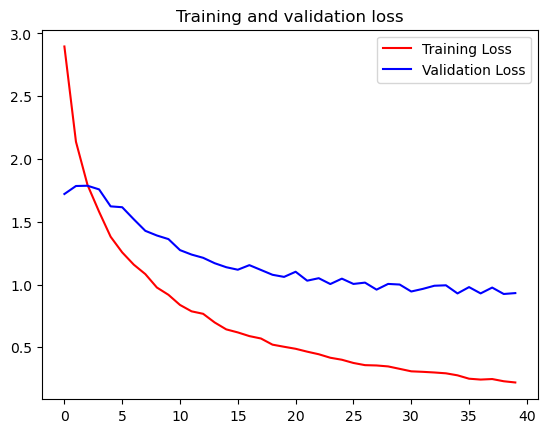

In [45]:
# DRAW Results
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [52]:
results = model.evaluate(test_images)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.7764 - loss: 1.0633
    Test Loss: 1.00112
Test Accuracy: 77.76%


In [55]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [60]:
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step


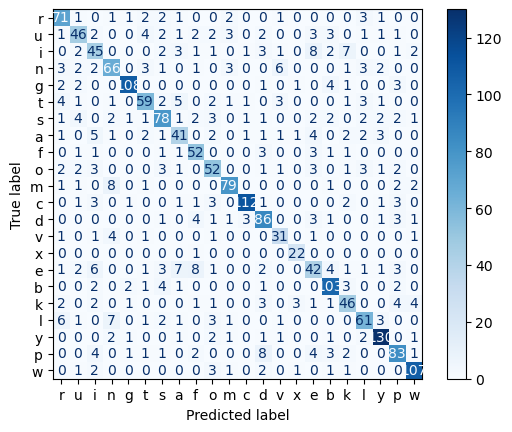

In [61]:
confusion_matrix = metrics.confusion_matrix(test_images.y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [47]:
model.export(WORK_DIR + TF_MODEL_DIR)

INFO:tensorflow:Assets written to: ../models/auslan_alphabet_classifier/assets


INFO:tensorflow:Assets written to: ../models/auslan_alphabet_classifier/assets


Saved artifact at '../models/auslan_alphabet_classifier/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_636')
Output Type:
  TensorSpec(shape=(None, 22), dtype=tf.float32, name=None)
Captures:
  33309323344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  33309324496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  33309324688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  33309324304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  33309323536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  33309325072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  33309326416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  33309326608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  33309326224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  33309325456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  33309323920: TensorSpec(shap

In [48]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(WORK_DIR + TF_MODEL_DIR) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(WORK_DIR + MODEL_DIR + 'auslan_alphabet_classifier_240927.tflite', 'wb') as f:
  f.write(tflite_model)

W0000 00:00:1727410762.470561  106014 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1727410762.471637  106014 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
